In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from   IPython.display import display, HTML
from collections import deque
import random
import os, pathlib, sys
from IPython.display import clear_output

In [31]:
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [32]:
parent_module_path = os.path.abspath(os.path.join('..'))
if parent_module_path not in sys.path:
    sys.path.append(parent_module_path)

In [33]:
import matplotlib.ticker as mtick
import matplotlib.dates as md
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter

tick    = mtick.StrMethodFormatter('\${x:,.0f}')
tick2    = mtick.StrMethodFormatter('\${x:,.2f}')
normal  = mtick.StrMethodFormatter('{x:,.0f}')
normal2 = mtick.StrMethodFormatter('{x:,.2f}')

In [34]:
def rescale_plot(W=5, rectangle=False):
    if rectangle:
        plt.rcParams.update({
            'figure.figsize': (W, W/(6/3)),     # 4:3 aspect ratio
            'font.size' : 8,                   # Set font size to 11pt
            'axes.labelsize': 8,               # -> axis labels
            'legend.fontsize': 8,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble': (            # LaTeX preamble
                r'\usepackage{lmodern}'
                # ... more packages if needed
            )
        })
    else:
        plt.rcParams.update({
            'figure.figsize': (W, W/(4/3)),     # 4:3 aspect ratio
            'font.size' : 8,                   # Set font size to 11pt
            'axes.labelsize': 8,               # -> axis labels
            'legend.fontsize': 8,              # -> legends
            'font.family': 'lmodern',
            'text.usetex': True,
            'text.latex.preamble': (            # LaTeX preamble
                r'\usepackage{lmodern}'
                # ... more packages if needed
            )
        })

In [35]:
def plot_fwd_predictive_power(predictive_feature, ax1, ax2, 
                              ax3, fwd_cols_st, fwd_cols_lt, 
                              fwd_cols_vlt, LOB_features, tick_size, 
                              round_value, cut_nb = 1000, smoothing = 2):
    for (ax, fwd_cols, titlen) in zip( (ax1, ax2, ax3), (fwd_cols_st, fwd_cols_lt, fwd_cols_vlt), ('st', 'lt', 'vlt')):
        counts = (LOB_features[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).count().iloc[1:-1])
        avgs   = (LOB_features[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).mean().iloc[1:-1]/tick_size)
        avgs[counts<cut_nb]=np.nan
        
        for ((ii, _), clirs) in zip(enumerate(fwd_cols), ( 'k', 'tan','grey', 'darkblue') ):
            ax.plot(avgs.iloc[:,0].rolling(smoothing).mean(), color=clirs)
            
        ax.legend([s.split('_')[-1]+' trades' for s in fwd_cols])
        ax.yaxis.tick_right()
        ax.yaxis.set_label_position("right")
        ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        ax.set_title(f'{predictive_feature}: {titlen}')

In [36]:
def add_fwd_cols(all_fwd_cols, _LOB_features):
    for col in all_fwd_cols:
        fwd_w = int(col.split('_')[-1])
        _LOB_features[col] = _LOB_features['mid_price'].diff(int(fwd_w/10)).shift(-int(fwd_w/10))

In [37]:
def fwd_predictive_power_curve(trade_date,
                               predictive_feature, fwd_cols, 
                               LOB_features, tick_size, 
                               round_value, cut_nb = 1000, smoothing = 2):
    features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'
    LOB_features  = pd.read_pickle(f'../data/Features/{features_fn}')    
    add_fwd_cols(fwd_cols, LOB_features)
    counts = (LOB_features[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).count().iloc[1:-1])
    avgs   = (LOB_features[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).mean().iloc[1:-1]/tick_size)
    stds   = (LOB_features[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).std().iloc[1:-1]/tick_size)
    
    avgs[counts<cut_nb]=np.nan
    stds[counts<cut_nb]=np.nan
    
    avgs = avgs.rolling(smoothing).mean()
    stds = stds.rolling(smoothing).mean()
    
    return avgs, stds, counts

In [38]:
def ema(series, periods, fillna=False):
    if fillna:
        return series.ewm(span=periods, min_periods=0).mean()
    return series.ewm(span=periods, min_periods=periods).mean()

def macd_signal(close, n_fast=12, n_slow=26, n_sign=9, fillna=False):
    emafast = ema(close, n_fast, fillna)
    emaslow = ema(close, n_slow, fillna)
    macd = emafast - emaslow
    macd = (macd - ema(macd, n_sign, fillna))
    macd = macd / close.shift(n_slow+n_sign)
    
    if fillna:
        macd = macd.replace([np.inf, -np.inf], np.nan).fillna(0)
        
    return pd.Series(macd, name='MACD')

In [39]:
from AOE.utils import get_LOB_data, get_LOB_features, verbose_print #get_features

In [40]:
fwd_cols_st, fwd_cols_lt, fwd_cols_vlt = [], [], []

fwd_col_l_st  = (1,  10,  50, 100)
fwd_col_l_lt  = (300, 500, 1000, 5000)
fwd_col_l_vlt = (10000, 20000, 50000, 100000)

for w in fwd_col_l_st:
    fwd_cols_st += [f'fwd_price_move_{w}']
for w in fwd_col_l_lt:
    fwd_cols_lt += [f'fwd_price_move_{w}']
for w in fwd_col_l_vlt:
    fwd_cols_vlt += [f'fwd_price_move_{w}']

all_fwd_cols = [f'fwd_price_move_{w}' for w in [1, 5, 10, 20, 50, 40, 60, 100, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000]]

In [41]:
fwd_cols_st, fwd_cols_lt, fwd_cols_vlt = [], [], []

fwd_col_l_st  = (50,)
fwd_col_l_lt  = (70,)
fwd_col_l_vlt = (1000,)

for w in fwd_col_l_st:
    fwd_cols_st += [f'fwd_price_move_{w}']
for w in fwd_col_l_lt:
    fwd_cols_lt += [f'fwd_price_move_{w}']
for w in fwd_col_l_vlt:
    fwd_cols_vlt += [f'fwd_price_move_{w}']

all_fwd_cols = [f'fwd_price_move_{w}' for w in [50, 70, 1000]]

# Predictive power for specific times

In [42]:
asset_name    = "BIDU"
trade_date    = '2022-10-03'
tick_size     = 0.01

features_fn   = f'{asset_name}_{trade_date}_LOB_features.pkl'
LOB_features  = pd.read_pickle(f'../data/Features/{features_fn}')
add_fwd_cols(all_fwd_cols, LOB_features)

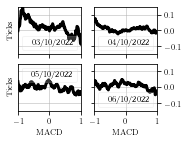

In [43]:
rescale_plot(W=2.5, rectangle=False)

fwd_mov_window = "fwd_price_move_70"
signal_name    = "macd_12_26_9"

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True)

trade_date_3 = '2022-01-19'
trade_date_3 = '2022-10-03'
curve_3, stds_3, counts_3      = fwd_predictive_power_curve(trade_date_3, 
                                                             signal_name, 
                                                             [fwd_mov_window],  
                                                             LOB_features, tick_size, 2, 10, 10)
ax1.plot(curve_3.index, curve_3.values, color='k', linewidth=3)
# ax1.fill_between(curve_3.index, (curve_3-stds_3).iloc[:,0].values
#                  , (curve_3+stds_3).iloc[:,0].values, color='gray', linewidth=3)

trade_date_4 = '2022-01-26' #
trade_date_4 = '2022-10-04' #
curve_4, stds_4, counts_4       = fwd_predictive_power_curve(trade_date_4, 
                                         signal_name, 
                                         [fwd_mov_window],  
                                         LOB_features, tick_size, 2, 10, 15)
ax2.plot(curve_4.index, curve_4.values, color='k', linewidth=3)
# ax2.fill_between(curve_4.index, (curve_4-stds_4).iloc[:,0].values
#                  , (curve_4+stds_4).iloc[:,0].values, color='gray', linewidth=3)

trade_date_1 = '2022-05-09' #'2022-06-29' #2022-05-09
trade_date_1 = '2022-10-05' #'2022-06-29' #2022-05-09
curve_1, stds_1, counts_1      = fwd_predictive_power_curve(trade_date_1, 
                                         signal_name, 
                                         [fwd_mov_window],  
                                         LOB_features, tick_size, 2, 10, 10)
ax3.plot(curve_1.index, curve_1.values, color='k', linewidth=3)
# ax3.fill_between(curve_1.index, (curve_1-stds_1).iloc[:,0].values
#                  , (curve_1+stds_1).iloc[:,0].values, color='gray', linewidth=3)

trade_date_2 = '2022-06-10' #2021-07-02  2021-09-07
trade_date_2 = '2022-10-06' #2021-07-02  2021-09-07
curve_2, stds_2, counts_2      = fwd_predictive_power_curve(trade_date_2, 
                                         signal_name, 
                                         [fwd_mov_window],  
                                         LOB_features, tick_size, 2, 10, 10)
ax4.plot(curve_2.index, curve_2.values, color='k', linewidth=3)
# ax4.fill_between(curve_2.index, (curve_2-stds_2).iloc[:,0].values
#                  , (curve_2+stds_2).iloc[:,0].values, color='gray', linewidth=3)

# ax1.set_title('19/01/2022')
# ax2.set_title('26/01/2022')
# ax3.set_title('09/05/2022')
# ax4.set_title('10/06/2022')

ax1.legend([trade_date_3.split('-')[2]+'/'+
            trade_date_3.split('-')[1]+'/'+
            trade_date_3.split('-')[0]], handlelength=0., framealpha=0.2, loc='best')
ax2.legend([trade_date_4.split('-')[2]+'/'+
            trade_date_4.split('-')[1]+'/'+
            trade_date_4.split('-')[0]], handlelength=0., framealpha=0.2, loc='best')
ax3.legend([trade_date_1.split('-')[2]+'/'+
            trade_date_1.split('-')[1]+'/'+
            trade_date_1.split('-')[0]], handlelength=0., framealpha=0.2, loc='best')
ax4.legend([trade_date_2.split('-')[2]+'/'+
            trade_date_2.split('-')[1]+'/'+
            trade_date_2.split('-')[0]], handlelength=0., framealpha=0.2, loc='best')

ax1.set_xlim( -1., 1.)
ax1.set_ylim( -0.15, 0.15)

for aax in (ax1, ax2, ax3, ax4):
    # x.xaxis.set_major_formatter(percc0)
    # aax.yaxis.tick_right()
    aax.yaxis.set_label_position("left")
    aax.grid(axis='both',  linestyle='-', linewidth=0.5)
    aax.set_axisbelow(True)

# ax2.set_xlim( -1, 1)
# ax2.set_ylim( -0.5, 0.5)

# ax1.xaxis.set_major_formatter(percc3)
ax1.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

ax3.tick_params("y", left=False, labelleft=False)
ax4.tick_params("y", right=True, labelright=True)

ax1.set_ylabel('Ticks')
ax3.set_ylabel('Ticks')
ax3.set_xlabel('MACD')
ax4.set_xlabel('MACD')

plt.savefig(f'plots/AOE1_{asset_name}.pdf', bbox_inches='tight')
plt.show()

In [17]:
# 2021-10-18 (2022-06-29) U shaped
# 2021-08-18, 2021-12-09,  2022-03-21 only extreme values (good quality)
# 2021-12-20 trend following (1000)
# 2022-03-17 trend following good quality 
# 2022-06-06 only large positive values
# 2021-08-23 with 500, trend following
# 2022-06-13 only large negative
# 2022-01-26 mean reversion with 10
# 2021-08-20 mean reversion good quality

#   2022-06-14  2022-04-01  (trend following)

In [18]:
# LOB_features.loc[i0:i0+1800]
# LOB_features['macd'] = macd_signal(LOB_features['mid_price'], n_fast=120, n_slow=260, n_sign=90, fillna=True)*1e5

In [47]:
path        = "../data/Features"
dir_list    = os.listdir(path)
dic_results = {}

In [61]:
hitratios_hist = {}
for filename in dir_list:
    if (('LOB_features' in filename) & (asset_name in filename)):
        trade_date    = filename.split('_')[1]
        #print(trade_date)
        # trade_date    = '2022-01-19'
        LOB_features  = pd.read_pickle(f'../data/Features/{filename}')
        add_fwd_cols(all_fwd_cols, LOB_features)

        y  = LOB_features.mid_price.diff(70).shift(-70).apply(np.sign).round()
        x1 = LOB_features.macd_12_26_9.apply(np.sign).round()
        x2 = LOB_features.imbalance_1.apply(np.sign).round()

        y[y==-1]   = 0
        x1[x1==-1] = 0
        x2[x2==-1] = 0

        x1[x1==-0.0] = 0
        x2[x2==-0.0] = 0

        hitratio1 = pd.concat((x1, y), axis=1).dropna()
        hitratio1.columns = ['x', 'y']
        hitratio1['hitratio'] = (hitratio1.x == hitratio1.y)

        hitratio2 = pd.concat((x2, y), axis=1).dropna()
        hitratio2.columns = ['x', 'y']
        hitratio2['hitratio'] = (hitratio2.x == hitratio2.y)

        hitratios = pd.concat((hitratio1.hitratio,hitratio2.hitratio), axis=1)
        hitratios.columns = ['MACD', 'Imbalance']
        
        hitratios_hist[trade_date] = hitratios.mean().values
        # print(trade_date)
        # print(hitratios.mean())
        # print('\n')

In [60]:
pd.DataFrame.from_dict(hitratios_hist).T.sort_values(by=0).tail()

,0,1
2022-10-24,0.497314,0.513117
2022-10-17,0.499112,0.534333
2022-10-26,0.501546,0.520868
2022-12-22,0.503180,0.534620
2022-12-19,0.503439,0.542149


In [64]:
LOB_features  = pd.read_pickle(f'../data/Features/{features_fn}')
add_fwd_cols(all_fwd_cols, LOB_features)

y  = LOB_features.mid_price.diff(70).shift(-70).apply(np.sign).round()
x1 = -LOB_features.macd_12_26_9.apply(np.sign).round()
x2 = LOB_features.macd_12_26_9.apply(np.sign).round()
x3 = LOB_features.imbalance_1.apply(np.sign).round()

# x2 = LOB_features.imbalance_1.apply(np.sign).round()
todrop = y[y==0].index

y.drop(todrop)
x1.drop(todrop)
x1.drop(todrop)

y[y==1]   = 0
x1[x1==1] = 0
x2[x2==1] = 0
x3[x3==1] = 0

x1[x1==-0.0] = 0
x2[x2==-0.0] = 0
x3[x3==-0.0] = 0

hitratio1 = pd.concat((x1, y), axis=1)
hitratio1.columns = ['x', 'y']
hitratio1['hitratio'] = (hitratio1.x == hitratio1.y)

hitratio2 = pd.concat((x2, y), axis=1)
hitratio2.columns = ['x', 'y']
hitratio2['hitratio'] = (hitratio2.x == hitratio2.y)

hitratio3 = pd.concat((x3, y), axis=1)
hitratio3.columns = ['x', 'y']
hitratio3['hitratio'] = (hitratio3.x == hitratio3.y)

hitratios = pd.concat((hitratio1.hitratio,
                       hitratio2.hitratio,
                       hitratio3.hitratio), axis=1)
hitratios.columns = ['MACD MR', 'MACD TF', 'Imbalance']
hitratios.index = LOB_features.timestamp

hitratios.mean().values

array([0.51899076, 0.48061626, 0.53196375])

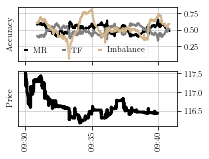

In [66]:
rolling_w = 70*60*2

range_ = '5min'

rescale_plot(W=2.8, rectangle=False)

fig, (ax, ax1)= plt.subplots(2, 1, sharex=True,  constrained_layout=True)

hit_ratios_to_plot = hitratios.rolling('1min').mean().iloc[1000:].first(range_)

ax.plot(hit_ratios_to_plot.index, 
         hit_ratios_to_plot.iloc[:, 0],
        color='k', linewidth=2)

ax.plot(hit_ratios_to_plot.index, 
         hit_ratios_to_plot.iloc[:, 1], 
       color = 'gray', linewidth=2)

ax.plot(hit_ratios_to_plot.index, 
         hit_ratios_to_plot.iloc[:, 2], 
        color = 'tan', linewidth=2)

ax1.plot(LOB_features.set_index('timestamp').first(range_).index,
         LOB_features.set_index('timestamp').first(range_).mid_price,
         color='k', linewidth=3)
ax.legend(['MR', 'TF', 'Imbalance'], 
          handlelength=0.2, framealpha=0.2, loc='best', ncol=3)

myFmt = DateFormatter("%H:%M")

ax.xaxis.set_major_formatter(myFmt)

for x in (ax,ax1):
    x.yaxis.tick_right()
    x.yaxis.set_label_position("left")
    x.grid(axis='both',  linestyle='-', linewidth=0.5)
    x.set_axisbelow(True)

# ax1.xaxis.set_major_formatter(percc3)

# ax.set_xlabel('Ticks')
ax.set_ylabel('Accuracy')
ax1.set_ylabel('Price')

ax1.tick_params(axis='x', rotation=90)

plt.savefig(f'plots/AOE3_{asset_name}.pdf', bbox_inches='tight')
plt.show()

In [361]:
trade_date    = '2022-06-10'
LOB_features  = pd.read_pickle(f'../data/Features2/LOB_features_{trade_date}.pkl')
add_fwd_cols(all_fwd_cols, LOB_features)

2022-10-03 12:18:00.152651
2022-10-03 12:23:58.486375


KeyboardInterrupt: 

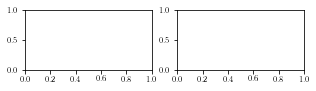

In [68]:
from time import sleep

rescale_plot(5)

for i in range(100):
    fig = plt.figure()
    gs  = gridspec.GridSpec(nrows=3, ncols=2)


    clear_output(wait=True)
    i0     = 34200
    from_i = i0 + (360)*i
    to_i   = from_i + 360

    # only some values are predictive
    # from_i = i0 + 1800*4
    # to_i   = from_i + 1800/2

    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    print(LOB_features.loc[from_i:to_i].iloc[0].timestamp)
    print(LOB_features.loc[from_i:to_i].iloc[-1].timestamp)
    
    plot_fwd_predictive_power('macd_12_26_9',
                              ax0, 
                              fig.add_subplot(gs[1, 0]), 
                              fig.add_subplot(gs[2, 0]), 
                              fwd_cols_st, fwd_cols_lt, fwd_cols_vlt, 
                              LOB_features.loc[from_i:to_i], tick_size, 2, 10, 10)

    plot_fwd_predictive_power('imbalance_1', 
                              ax1, 
                              fig.add_subplot(gs[1, 1]), 
                              fig.add_subplot(gs[2, 1]), 
                              fwd_cols_st, fwd_cols_lt, fwd_cols_vlt, 
                              LOB_features.loc[from_i:to_i], tick_size, 2, 0, 10)

    # ax1.set_ylabel('Average forward price move in number of ticks')
    plt.title('Predictive power: trend signal')
    plt.title('Predictive power: imbalance signal')
    plt.tight_layout()
    plt.show()
    sleep(2)

# plt.savefig('MSFT_predictive_features.pdf')

In [ ]:
i 

2021-10-04 09:30:00.000121
2021-10-04 09:35:59.825343


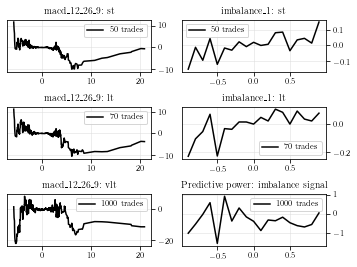

In [559]:
from time import sleep

rescale_plot(5)

i = 0

fig = plt.figure()
gs  = gridspec.GridSpec(nrows=3, ncols=2)


clear_output(wait=True)
i0     = 34200
from_i = i0 + (360)*i
to_i   = from_i + 360

# only some values are predictive
# from_i = i0 + 1800*4
# to_i   = from_i + 1800/2

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

print(LOB_features.loc[from_i:to_i].iloc[0].timestamp)
print(LOB_features.loc[from_i:to_i].iloc[-1].timestamp)

plot_fwd_predictive_power('macd_12_26_9',
                          ax0, 
                          fig.add_subplot(gs[1, 0]), 
                          fig.add_subplot(gs[2, 0]), 
                          fwd_cols_st, fwd_cols_lt, fwd_cols_vlt, 
                          LOB_features.loc[from_i:to_i], tick_size, 2, 0, 10)

plot_fwd_predictive_power('imbalance_1', 
                          ax1, 
                          fig.add_subplot(gs[1, 1]), 
                          fig.add_subplot(gs[2, 1]), 
                          fwd_cols_st, fwd_cols_lt, fwd_cols_vlt, 
                          LOB_features.loc[from_i:to_i], tick_size, 1, 0, 1)

# ax1.set_ylabel('Average forward price move in number of ticks')
plt.title('Predictive power: trend signal')
plt.title('Predictive power: imbalance signal')
plt.tight_layout()
plt.show()

# plt.savefig('MSFT_predictive_features.pdf')

In [170]:
31-32
19-10
42-43
43-44
45-46
46-47

25-30


# def plot_fwd_predictive_power_seconds(predictive_feature, ax1, ax2, ax3, fwd_cols_st, fwd_cols_lt, fwd_cols_vlt, LOB_features, tick_size, round_value):
#     for (ax, fwd_cols, titlen) in zip( (ax1, ax2, ax3), (fwd_cols_st, fwd_cols_lt, fwd_cols_vlt), ('st', 'lt', 'vlt')):
#         counts = (LOB_features[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).count().iloc[1:-1])
#         avgs   = (LOB_features[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).mean().iloc[1:-1]/tick_size)
#         avgs[counts<500]=np.nan
        
#         ax.plot(avgs.iloc[:,0], color='tan')
#         ax.plot(avgs.iloc[:,1], color='k')
#         ax.plot(avgs.iloc[:,2], color='grey')
#         ax.plot(avgs.iloc[:,3], color='darkblue')
        
#         ax.legend([s.split('_')[-1]+' trades' for s in fwd_cols])
#         ax.yaxis.tick_right()
#         # ax.tick_params(axis='both', **config_ticks)
#         ax.yaxis.set_label_position("right")
#         # ax.yaxis.label.set_color('grey')
#         ax.grid(axis='both', color='gainsboro', linestyle='-', linewidth=0.5)
#         ax.set_axisbelow(True)
#         ax.set_title(f'{predictive_feature}: {titlen}')

In [101]:
# LOB_features_t = LOB_features.set_index('timestamp')
# LOB_features_t['fwd_10ms']  = LOB_features_t.mid_price.rolling('10ms').apply(lambda x: x[-1] - x[0])
# LOB_features_t['fwd_100ms'] = LOB_features_t.mid_price.rolling('100ms').apply(lambda x: x[-1] - x[0])
# LOB_features_t['fwd_500ms'] = LOB_features_t.mid_price.rolling('500s').apply(lambda x: x[-1] - x[0])
# LOB_features_t['fwd_1s']    = LOB_features_t.mid_price.rolling('1s').apply(lambda x: x[-1] - x[0])
# LOB_features_t['fwd_1m']    = LOB_features_t.mid_price.rolling('60s').apply(lambda x: x[-1] - x[0])

In [102]:
# predictive_feature = 'imbalance_1'
# round_value = 3
# fwd_cols = [f'fwd_{s}' for s in ['10ms', '100ms', '500ms', '1s', '1m']] #

In [103]:
# LOB_features.iloc[::50]

In [104]:
# counts = (LOB_features_t[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).count().iloc[1:-1])
# avgs   = (LOB_features_t[[predictive_feature] + fwd_cols].round(round_value).groupby(predictive_feature).mean().iloc[1:-1]/tick_size)

# # avgs[counts<500]=np.nan

# fig, ax = plt.subplots(1, 1)

# ax.plot(avgs.iloc[:,0], color='tan')
# ax.plot(avgs.iloc[:,1], color='k')
# ax.plot(avgs.iloc[:,2], color='grey')
# ax.legend(avgs.columns)
# # ax.plot(avgs.iloc[:,3], color='darkblue')

### Activity dynamics

In [264]:
path        = "../data/Features2"
dir_list    = os.listdir(path)
dic_results = {}

In [269]:
for filename in dir_list:
    if 'LOB_features' in filename:
        trade_date    = filename.split('_')[-1].split(".")[0]        
        print('Reading:',trade_date)
        
        LOB_features = pd.read_pickle(f'../data/Features2/LOB_features_{trade_date}.pkl')
        tmpActivityDF_1min = LOB_features[['mid_price', 'timestamp']].set_index('timestamp').resample('1min').count()
        tmpActivityDF_1min.index = [pd.to_datetime(s).time() for s in tmpActivityDF_1min.index]
        
        tmpActivityDF_1s = LOB_features[['mid_price', 'timestamp']].set_index('timestamp').resample('1s').count()
        tmpActivityDF_1s.index = [pd.to_datetime(s).time() for s in tmpActivityDF_1s.index]
        
        dic_results[trade_date] = (tmpActivityDF_1s, tmpActivityDF_1min)
        clear_output(wait=True)

Reading: 2021-10-04


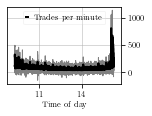

In [270]:
rescale_plot(2.)

fig, ax = plt.subplots(1, 1, constrained_layout=True, sharex=True, sharey=True)

# macd
avgs = pd.concat((dic_results[s][0] for s in dic_results.keys()), axis=1).mean(axis=1)#.rolling(20).mean()
stds = pd.concat((dic_results[s][0] for s in dic_results.keys()), axis=1).std(axis=1)

avgs.plot(ax=ax, color='k', linewidth=2)
ax.fill_between( avgs.index,avgs-stds,avgs+stds,
                facecolor='silver', hatch="ooo", edgecolor="gray")

ax.legend(['Trades per minute'], handlelength=0.2, framealpha=0.2, loc='upper center')
# ax.set_xlim( -1, 1)
# ax.set_ylim( -0.2, 0.2)

ax.yaxis.set_label_position("left")
ax.grid(axis='both',  linestyle='-', linewidth=0.5)
ax.set_axisbelow(True)
ax.yaxis.tick_right()
# ax.set_ylabel('Ticks')
ax.set_xlabel('Time of day')

locs = ax.get_xticks()
new_xticks=['', avgs.iloc[[int(len(avgs) * 0.25) ]].index[0].hour, 
              avgs.iloc[[int(len(avgs) * 0.75) ]].index[0].hour, '']
ax.set_xticks(locs, new_xticks)
ax.set_xlim(datetime.time(9, 0),datetime.time(16, 30))

plt.savefig('Ushaped.pdf', bbox_inches='tight')
# plt.show()

In [281]:
# allmean/len(dir_list)

In [279]:
# dir_list

In [282]:
# allmean = 0
# for filename in dir_list:
#     if 'LOB_features' in filename:
#         trade_date    = filename.split('_')[-1].split(".")[0]        
#         LOB_features = pd.read_pickle(f'../data/Features2/LOB_features_{trade_date}.pkl')
#         allmean += LOB_features[['mid_price', 'timestamp']].set_index('timestamp').resample('1s').count().mean()


### Average predictive power

In [251]:
from AOE.utils import get_LOB_data, get_LOB_features, get_meta_order_df, verbose_print

In [252]:
path     = "../data/Features2"
dir_list = os.listdir(path)
dic_results = {}

In [477]:
feature_1_name= 'macd_12_26_9'; feature_1_rounding = 2
feature_2_name= 'imbalance_1';  feature_2_rounding = 2

for filename in dir_list:
    if 'LOB_features' in filename:
        trade_date    = filename.split('_')[-1].split(".")[0]        
        # if '2022-06' in trade_date:
        print('Reading:',trade_date)
        if not trade_date in dic_results.keys():
            LOB_features = pd.read_pickle(f'../data/Features2/LOB_features_{trade_date}.pkl')
            
            add_fwd_cols(all_fwd_cols, LOB_features)

            LOB_features[feature_1_name] = LOB_features[feature_1_name].round(feature_1_rounding)
            LOB_features[feature_2_name] = LOB_features[feature_2_name].round(feature_2_rounding)
            LOB_features_predictive = LOB_features[[feature_1_name, feature_2_name, feature_3_name] + all_fwd_cols].dropna()

            predictive_feature = feature_1_name
            counts1 = (LOB_features_predictive[[predictive_feature] + all_fwd_cols].groupby(predictive_feature).count())
            avgs1   = (LOB_features_predictive[[predictive_feature] + all_fwd_cols].groupby(predictive_feature).mean()/tick_size)
            avgs1[counts1<100]=np.nan
            avgs1 = avgs1.sort_index().fillna(method='ffill').fillna(method='bfill')
            avgs1 = avgs1 - LOB_features_predictive[all_fwd_cols].mean()/tick_size

            predictive_feature = feature_2_name
            counts2 = (LOB_features_predictive[[predictive_feature] + all_fwd_cols].groupby(predictive_feature).count())
            avgs2   = (LOB_features_predictive[[predictive_feature] + all_fwd_cols].groupby(predictive_feature).mean()/tick_size)
            avgs2[counts2<100]=np.nan
            avgs2 = avgs2.sort_index().fillna(method='ffill').fillna(method='bfill')
            avgs2 = avgs2 - LOB_features_predictive[all_fwd_cols].mean()/tick_size


            dic_results[trade_date] = (counts1, avgs1, 
                                       counts2, avgs2)

Reading: 2021-10-21
Reading: 2021-09-28
Reading: 2021-09-14
Reading: 2022-05-20
Reading: 2022-02-15
Reading: 2021-12-30
Reading: 2022-05-09
Reading: 2022-02-14
Reading: 2021-12-31
Reading: 2022-02-28
Reading: 2021-09-15
Reading: 2021-09-01
Reading: 2021-09-29
Reading: 2021-10-20
Reading: 2021-10-08
Reading: 2021-10-22
Reading: 2021-07-06
Reading: 2021-07-12
Reading: 2021-09-17
Reading: 2021-09-03
Reading: 2022-05-23
Reading: 2021-12-27
Reading: 2022-02-16
Reading: 2022-02-17
Reading: 2021-09-02
Reading: 2021-09-16
Reading: 2021-07-13
Reading: 2021-07-07
Reading: 2021-10-27
Reading: 2021-12-22
Reading: 2022-05-26
Reading: 2022-05-27
Reading: 2021-12-23
Reading: 2021-07-16
Reading: 2021-07-02
Reading: 2021-09-07
Reading: 2021-09-13
Reading: 2021-10-26
Reading: 2021-10-18
Reading: 2021-07-28
Reading: 2021-07-14
Reading: 2022-05-19
Reading: 2021-12-21
Reading: 2021-12-09
Reading: 2022-05-25
Reading: 2022-05-31
Reading: 2022-05-24
Reading: 2021-12-08
Reading: 2021-12-20
Reading: 2022-05-18


In [479]:
# counts1

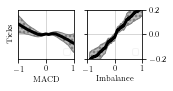

In [263]:
rescale_plot(2.3, True)

fig, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True, sharex=True, sharey=True)

# macd
feature_name = 'macd_12_26_9'; feature_rounding = 2
fwd_cols_    = ['fwd_price_move_50']

i    = 0
avgs = pd.concat((pd.concat((dic_results[s][2*i+1][colname].rolling(10).mean() for s in dic_results.keys()), axis=1).mean(axis=1).dropna() for colname in fwd_cols_), axis=1)
avgs.plot(ax=ax, color='k', linewidth=3)
ax.fill_between( (avgs-pd.concat((dic_results[key_][1][fwd_cols_].rolling(10).mean() for key_ in dic_results.keys()), axis=1).std(axis=1).to_frame()).index,
                (avgs-1*pd.concat( (dic_results[key_][1][fwd_cols_].rolling(10).mean() for key_ in dic_results.keys()), axis=1).std(axis=1).to_frame()).values[:,0],
                (avgs+1*pd.concat((dic_results[key_][1][fwd_cols_].rolling(10).mean() for key_ in dic_results.keys()), axis=1).std(axis=1).to_frame()).values[:,0],
                facecolor='silver', hatch="ooo", edgecolor="gray")

# imbalance
feature_name = 'imbalance_1'; feature_rounding = 2
fwd_cols_    = ['fwd_price_move_50']
i    = 1
avgs = pd.concat((pd.concat((dic_results[s][2*i+1][colname].rolling(10).mean() for s in dic_results.keys()), axis=1).mean(axis=1).dropna() for colname in fwd_cols_), axis=1)

avgs.plot(ax=ax2, color='k', linewidth=3)
ax2.fill_between( (avgs-pd.concat((dic_results[key_][3][fwd_cols_].rolling(10).mean() for key_ in dic_results.keys()), axis=1).std(axis=1).to_frame()).index,
                (avgs-2*pd.concat( (dic_results[key_][3][fwd_cols_].rolling(10).mean() for key_ in dic_results.keys()), axis=1).std(axis=1).to_frame()).values[:,0],
                (avgs+2*pd.concat((dic_results[key_][3][fwd_cols_].rolling(10).mean() for key_ in dic_results.keys()), axis=1).std(axis=1).to_frame()).values[:,0],
                facecolor='silver', hatch="ooo", edgecolor="gray")


ax.legend([], handlelength=0.2, framealpha=0.2, loc='lower right')
ax2.legend([], handlelength=0.2, framealpha=0.2, loc='lower right')

ax.set_xlim( -1, 1)
ax.set_ylim( -0.2, 0.2)

for aax in (ax, ax2):
    aax.yaxis.set_label_position("left")
    aax.grid(axis='both',  linestyle='-', linewidth=0.5)
    aax.set_axisbelow(True)
    
ax.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

ax.set_ylabel('Ticks')
ax2.set_xlabel('Imbalance')
ax.set_xlabel('MACD')

plt.savefig('AOE0.pdf', bbox_inches='tight')
plt.show()

# plt.show()

<AxesSubplot:>

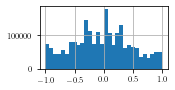

In [522]:
LOB_features.imbalance_1.hist(bins=30)

<AxesSubplot:xlabel='macd_12_26_9'>

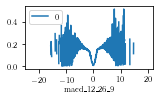

In [495]:
(stds).plot()

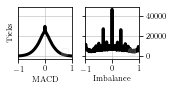

In [525]:
rescale_plot(2.3, True)
fwd_cols_    = ['fwd_price_move_70']

fig, (ax, ax2) = plt.subplots(1, 2, constrained_layout=True, sharex=True, sharey=True)

# macd
avgs = pd.concat((pd.concat((dic_results[s][0][colname] for s in dic_results.keys()), axis=1).mean(axis=1).dropna() for colname in fwd_cols_), axis=1)
stds = (pd.concat( (dic_results[key_][1][fwd_cols_] for key_ in dic_results.keys()), axis=1).std(axis=1).to_frame())
avgs.plot(ax=ax, color='k', linewidth=3)

# imbalance
avgs = pd.concat((pd.concat((dic_results[s][2][colname] for s in dic_results.keys()), axis=1).mean(axis=1).dropna() for colname in fwd_cols_), axis=1)
avgs.rolling(2).mean().plot(ax=ax2, color='k', linewidth=3)


ax.legend([], handlelength=0.2, framealpha=0.2, loc='lower right')
ax2.legend([], handlelength=0.2, framealpha=0.2, loc='lower right')

ax.set_xlim( -1, 1)
ax2.set_xlim( -1, 1)

# ax.set_ylim( -0.2, 0.2)

for aax in (ax, ax2):
    aax.yaxis.set_label_position("left")
    aax.grid(axis='both',  linestyle='-', linewidth=0.5)
    aax.set_axisbelow(True)

ax.tick_params("y", left=False, labelleft=False)
ax2.tick_params("y", right=True, labelright=True)

ax.set_ylabel('Ticks')
ax2.set_xlabel('Imbalance')
ax.set_xlabel('MACD')

plt.savefig('AOE2.pdf', bbox_inches='tight')
plt.show()

# plt.show()

In [526]:
avgs

,0
imbalance_1,
-1.00,1917.220532
-0.99,11762.722433
-0.98,12426.513308
-0.97,6363.809886
-0.96,10314.197719
...,...
0.96,9112.224335
0.97,5693.718631
0.98,10320.612167


In [57]:
i=1
avgs1 = pd.concat((pd.concat((dic_results[s][2*i+1][colname] for s in dic_results.keys()), axis=1
                            ).dropna().mean(axis=1).rolling(5).mean() for colname in all_fwd_cols), axis=1)    
avgs1.columns = all_fwd_cols
avgs1.fillna(method='bfill').to_pickle('macd_model.pkl')

i=0
avgs2 = pd.concat((pd.concat((dic_results[s][2*i+1][colname] for s in dic_results.keys()), axis=1
                            ).dropna().mean(axis=1).rolling(5).mean() for colname in all_fwd_cols), axis=1)    
avgs2.columns = all_fwd_cols
avgs2.fillna(method='bfill').to_pickle('macd_model.pkl')
# avgs2.fillna(method='bfill').to_pickle('imb_model.pkl')

In [ ]:
# # rolling averaged predicted movement
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# predictive_feature = 'imbalance_1_rounded'
# rolling_predictive_power = LOB_features_predictive[[predictive_feature, 'Avg_price_move_60']]
# reindex_features = LOB_features.loc[rolling_predictive_power.index]
# # rolling_predictive_power.index = .timestamp
# rolling_predictive_power = pd.concat( (rolling_predictive_power.iloc[-i:-i+3000].groupby(predictive_feature).mean().T/tick_size for i in range(3001,len(rolling_predictive_power),1000)), axis=0)
# rolling_predictive_power.index = (reindex_features.timestamp.values[-i+3000] for i in range(3001,len(LOB_features_predictive),1000))
# rolling_predictive_power[::-1].loc[:,np.sort(LOB_features_predictive[predictive_feature].unique())].loc[:, -1:-0.75].fillna(method='ffill').mean(axis=1).plot(color='k', ax=ax1)

# predictive_feature = 'price_trend_2_rounded'
# rolling_predictive_power = LOB_features_predictive[[predictive_feature, 'Avg_price_move_60']]
# reindex_features = LOB_features.loc[rolling_predictive_power.index]
# # rolling_predictive_power.index = .timestamp
# rolling_predictive_power = pd.concat( (rolling_predictive_power.iloc[-i:-i+3000].groupby(predictive_feature).mean().T/tick_size for i in range(3001,len(rolling_predictive_power),1000)), axis=0)
# rolling_predictive_power.index = (reindex_features.timestamp.values[-i+3000] for i in range(3001,len(LOB_features_predictive),1000))
# rolling_predictive_power[::-1].loc[:,np.sort(LOB_features_predictive[predictive_feature].unique())].loc[:, -0.004:-0.002].fillna(method='ffill').mean(axis=1).plot(color='k', ax=ax2)

# Evidence of non stationarity

In [ ]:
trade_date    = '2014-09-02'
tick_size     = 0.001
LOB_data      = get_LOB_data(f'{os.getcwd()}/{data_path}' , asset_name, trade_date)
LOB_features  = get_features(LOB_data,
                             trade_date = trade_date,
                             trend      = ({'w' : 50},),
                             vol        = (),
                             depth      = {'w' : 500})
LOB_features_predictive = LOB_features[['imbalance_1_rounded',
                                        'imbalance_2_rounded',
                                        "trend_0_rounded",'fwd_price_move_5', 'fwd_price_move_10', 
                                        'fwd_price_move_20', 'fwd_price_move_50', 'fwd_price_move_100']].dropna()

In [ ]:
fwd_cols             = ['fwd_price_move_5', 'fwd_price_move_20', 'fwd_price_move_50', 'fwd_price_move_100']
predictive_feature_1 = 'imbalance_1_rounded'
predictive_feature_2 = 'imbalance_2_rounded'
fwd_window           = 'fwd_price_move_50'

df_predictive_power  = LOB_features_predictive[[fwd_window, predictive_feature_1, predictive_feature_2]]
df_predictive_power[fwd_window] = df_predictive_power[fwd_window]/tick_size

In [ ]:
avgs1_ = avgs1.reindex(avgs1.index.union(df_predictive_power[predictive_feature_1].unique())).sort_index().fillna(method='ffill').fillna(method='bfill')
avgs2_ = avgs2.reindex(avgs2.index.union(df_predictive_power[predictive_feature_2].unique())).sort_index().fillna(method='ffill').fillna(method='bfill')

avgs1_     = avgs1_[fwd_window]
avgs2_     = avgs2_[fwd_window]

In [ ]:
# avgs1

In [ ]:
rolling_w            = 5000
lastwindow           = '4h'

# df_predictive_power[predictive_feature_1] = df_predictive_power[predictive_feature_1].round(4)
# df_predictive_power[predictive_feature_1] = df_predictive_power[predictive_feature_1].round(2)

df_predictive_power['predictive_move_feature_1'] = avgs1_.loc[df_predictive_power[predictive_feature_1]].values
df_predictive_power['predictive_move_feature_2'] = avgs2_.loc[df_predictive_power[predictive_feature_2]].values

print(LOB_features.timestamp.diff(rolling_w).mean()/np.timedelta64(1,"s"))

df_predictive_power['MAE_feature_1'] = ((df_predictive_power[fwd_window] - \
                                        df_predictive_power["predictive_move_feature_1"]).abs()
                                       ).rolling(rolling_w, min_periods=rolling_w).mean()

df_predictive_power['MAE_feature_2'] = ((df_predictive_power[fwd_window] - \
                                        df_predictive_power["predictive_move_feature_2"]).abs()
                                       ).rolling(rolling_w, min_periods=rolling_w).mean()

# df_predictive_power = df_predictive_power.iloc[0:len(df_predictive_power):rolling_w]

best_dynamics_feature = df_predictive_power[['MAE_feature_1', 'MAE_feature_2']].idxmin(axis=1).dropna()

best_dynamics_feature[ best_dynamics_feature== 'MAE_feature_1'] = 1
best_dynamics_feature[ best_dynamics_feature== 'MAE_feature_2'] = 2

print(len(np.diff(best_dynamics_feature.diff(1)[best_dynamics_feature.diff(1)!=0])))
print(np.mean(np.diff(best_dynamics_feature.diff(1)[best_dynamics_feature.diff(1)!=0].index.values)))

fig, (ax1, ax2) = plt.subplots(1, 2)

pd.concat((LOB_features.loc[best_dynamics_feature.index].timestamp, 
           best_dynamics_feature), axis=1
         ).set_index('timestamp').first(lastwindow).plot(ax=ax1)

pd.concat((LOB_features.loc[best_dynamics_feature.index].timestamp, best_dynamics_feature
          ), axis=1).set_index('timestamp').last(lastwindow).plot(ax=ax2)

In [ ]:
# w = 1000000

df_to_plot = pd.concat((LOB_features.loc[df_predictive_power.index].timestamp, 
                        df_predictive_power), axis=1)
# plt.plot(LOB_features.loc[df_predictive_power.iloc[:w].index].timestamp.values,
#           df_predictive_power[['MAE_feature_1']].iloc[:w].values, color='k')
# plt.plot(LOB_features.loc[df_predictive_power.iloc[:w].index].timestamp.values,
#           df_predictive_power[['MAE_feature_2']].iloc[:w].values, color='blue')
# df_to_plot.set_index('timestamp').last('8h')[['MAE_feature_1', 'MAE_feature_2']].plot()
df_to_plot.reset_index().iloc[-200000:][['MAE_feature_1', 'MAE_feature_2']].plot()


In [ ]:
LOB_features.loc[df_predictive_power.iloc[-w:].index].timestamp.values

In [ ]:
cols = rolling_predictive_power.Avg_price_move_60.unique()